# Fase 2: MLOps - Pipeline with Experiment Tracking

This notebook implements the second phase of the MLOps project for the "Insurance Company Benchmark" (COIL 2000) dataset. 

**Objective:** Predict whether a client will purchase a caravan insurance policy.

This version refactors the original notebook by moving all reusable logic (data cleaning, feature engineering, and model training) into Python modules within the `src/` directory, following MLOps best practices. It also integrates **MLflow** to track experiments, log parameters, metrics, and models, and manage the model lifecycle.

## 1. Setup and Imports

First, we add the project's root directory to the system path to allow imports from `src/`. We then import our custom modules and necessary libraries.

In [16]:
import sys
import os
import pandas as pd
import warnings
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- MLflow --- 
import mlflow
import mlflow.sklearn
from mlflow import MlflowClient

# --- Enable autologging (Hybrid Approach) ---
# We tell autolog to log models, but NOT its default metrics.
# We will log our own custom metrics manually.
mlflow.sklearn.autolog(
    log_models=True,                     # Automatically log the pipeline
    log_post_training_metrics=False,   # Turn OFF default metrics
    registered_model_name=None         # We control registration manually
)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Add the project root (assuming this notebook is in 'notebooks/') to the path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Define the correct MLflow URI ---
project_root_path = Path(project_root)
MLRUNS_URI = (project_root_path / "mlruns").as_uri()

# Import custom modules from src/
from src import config
from src import dataset
from src import features
from src import plots
from src.modeling import train

# Reload modules to pick up changes
importlib.reload(config)
importlib.reload(dataset)
importlib.reload(features)
importlib.reload(plots)
importlib.reload(train)

<module 'src.modeling.train' from 'c:\\Users\\jorge\\OneDrive\\Documents\\GIT\\insurance_company_project\\src\\modeling\\train.py'>

## 2. Data Cleaning

We execute the complete data cleaning pipeline defined in `src/dataset.py`. This script loads the raw data, repairs out-of-range values, imputes missing data, and saves the cleaned result to `data/processed/`.

In [17]:
dataset.clean_raw_data(
    in_path=config.RAW_DATA_PATH,
    out_path=config.PROCESSED_DATA_PATH,
    columns=config.COLS,
    expected_ranges=config.EXPECTED_RANGES,
    rare_threshold=config.RARE_THRESHOLD
)

2025-10-29 01:03:33,335 - INFO - --- Data Cleaning Pipeline Started ---
2025-10-29 01:03:33,648 - INFO - Loaded raw data: (5938, 86)
2025-10-29 01:03:33,653 - INFO - MOSTYPE: 75 (1.26%) values out of range [1,41]
2025-10-29 01:03:33,661 - INFO -   -> Widespread: Clipped to range
2025-10-29 01:03:33,663 - INFO - MAANTHUI: 69 (1.16%) values out of range [1,10]
2025-10-29 01:03:33,669 - INFO -   -> Widespread: Clipped to range
2025-10-29 01:03:33,672 - INFO - MGEMOMV: 64 (1.08%) values out of range [1,6]
2025-10-29 01:03:33,678 - INFO -   -> Widespread: Clipped to range
2025-10-29 01:03:33,680 - INFO - MGEMLEEF: 73 (1.23%) values out of range [1,6]
2025-10-29 01:03:33,683 - INFO -   -> Widespread: Clipped to range
2025-10-29 01:03:33,685 - INFO - MOSHOOFD: 58 (0.98%) values out of range [1,10]
2025-10-29 01:03:33,688 - INFO -   -> Rare: Set to NaN (will be imputed)
2025-10-29 01:03:33,695 - INFO - CARAVAN: 22 (0.37%) values out of range [0,1]
2025-10-29 01:03:33,697 - INFO -   -> Rare: Se

## 3. Load Processed Data

Now we load the clean, processed data. We also assign the descriptive column names from `src/config.py` for better readability.

In [18]:
df_cleaned = dataset.load_processed_data(config.PROCESSED_DATA_PATH)

# Assign descriptive names
df_cleaned.columns = config.LONG_NAMES

df_cleaned.head()

2025-10-29 01:03:37,187 - INFO - Loaded processed data from: C:\Users\jorge\OneDrive\Documents\GIT\insurance_company_project\data\processed\insurance_company_cleaned_modified.csv


,customer_subtype,num_houses,avg_household_size,avg_age_band,customer_main_type,pct_roman_catholic,pct_protestant,pct_other_religion,pct_no_religion,pct_married,pct_living_together,pct_other_relation,pct_singles,pct_household_no_kids,pct_household_with_kids,pct_high_education,pct_medium_education,pct_low_education,pct_high_status,pct_entrepreneur,pct_farmer,pct_middle_management,pct_skilled_labour,pct_unskilled_labour,pct_social_class_a,pct_social_class_b1,pct_social_class_b2,pct_social_class_c,pct_social_class_d,pct_rented_house,pct_home_owner,pct_one_car,pct_two_cars,pct_no_car,pct_national_health_service,pct_private_health_insurance,pct_income_lt_30k,pct_income_30k_45k,pct_income_45k_75k,pct_income_75k_122k,pct_income_gt_123k,pct_avg_income,purchasing_power_class,contr_private_third_party,contr_third_party_firms,contr_third_party_agriculture,contr_car_policies,contr_delivery_van_policies,contr_motorcycle_policies,contr_lorry_policies,contr_trailer_policies,contr_tractor_policies,contr_agri_machine_policies,contr_moped_policies,contr_life_ins,contr_private_accident,contr_family_accident,contr_disability_ins,contr_fire_policies,contr_surfboard_policies,contr_boat_policies,contr_bicycle_policies,contr_property_ins,contr_social_security,num_private_third_party,num_third_party_firms,num_third_party_agriculture,num_car_policies,num_delivery_van_policies,num_motorcycle_policies,num_lorry_policies,num_trailer_policies,num_tractor_policies,num_agri_machine_policies,num_moped_policies,num_life_ins,num_private_accident,num_family_accident,num_disability_ins,num_fire_policies,num_surfboard_policies,num_boat_policies,num_bicycle_policies,num_property_ins,num_social_security,target_caravan
0,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,2,2,5,2,2,2,3,6,2,2,8,8,0,1,8,1,0,4,5,0,1,4,3,1,1,1,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
1,37,1,2,2,8,1,4,0,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,6,1,2,6,3,2,0,5,2,0,5,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
2,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,0,3,4,2,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
3,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,0,4,4,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
4,40,1,4,2,10,1,4,1,4,7,1,2,0,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,0,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0


## 4. Exploratory Data Analysis (EDA)

With the clean data, we call our reusable plot functions from `src/plots.py` to understand the data.

2025-10-29 01:03:40,464 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-29 01:03:40,477 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


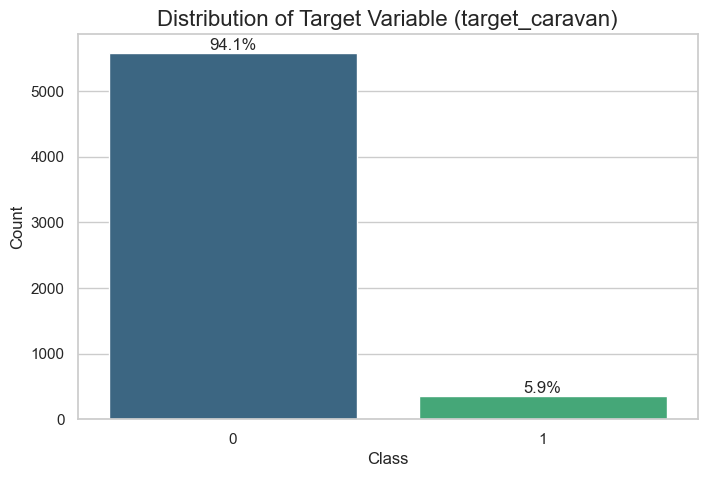

In [19]:
# 1. Target Variable Distribution
plots.plot_target_distribution(df_cleaned, config.TARGET_COL)

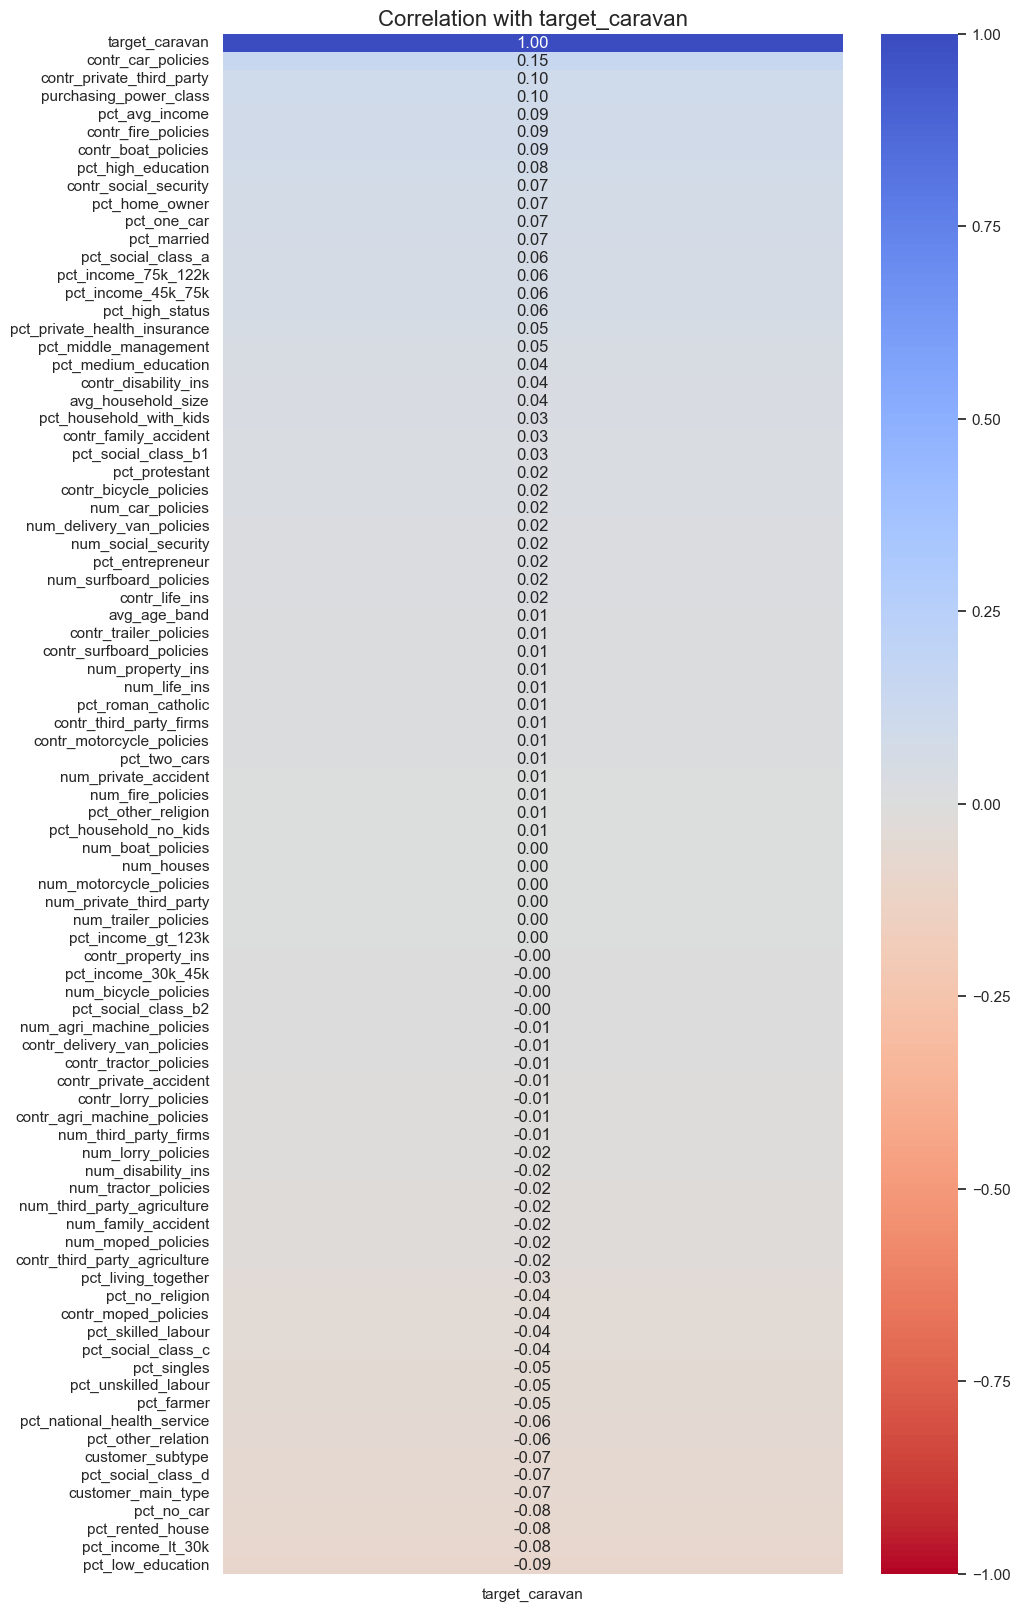

In [20]:
# 2. Feature Correlation with Target
plots.plot_correlation_heatmap(df_cleaned, target_col=config.TARGET_COL)

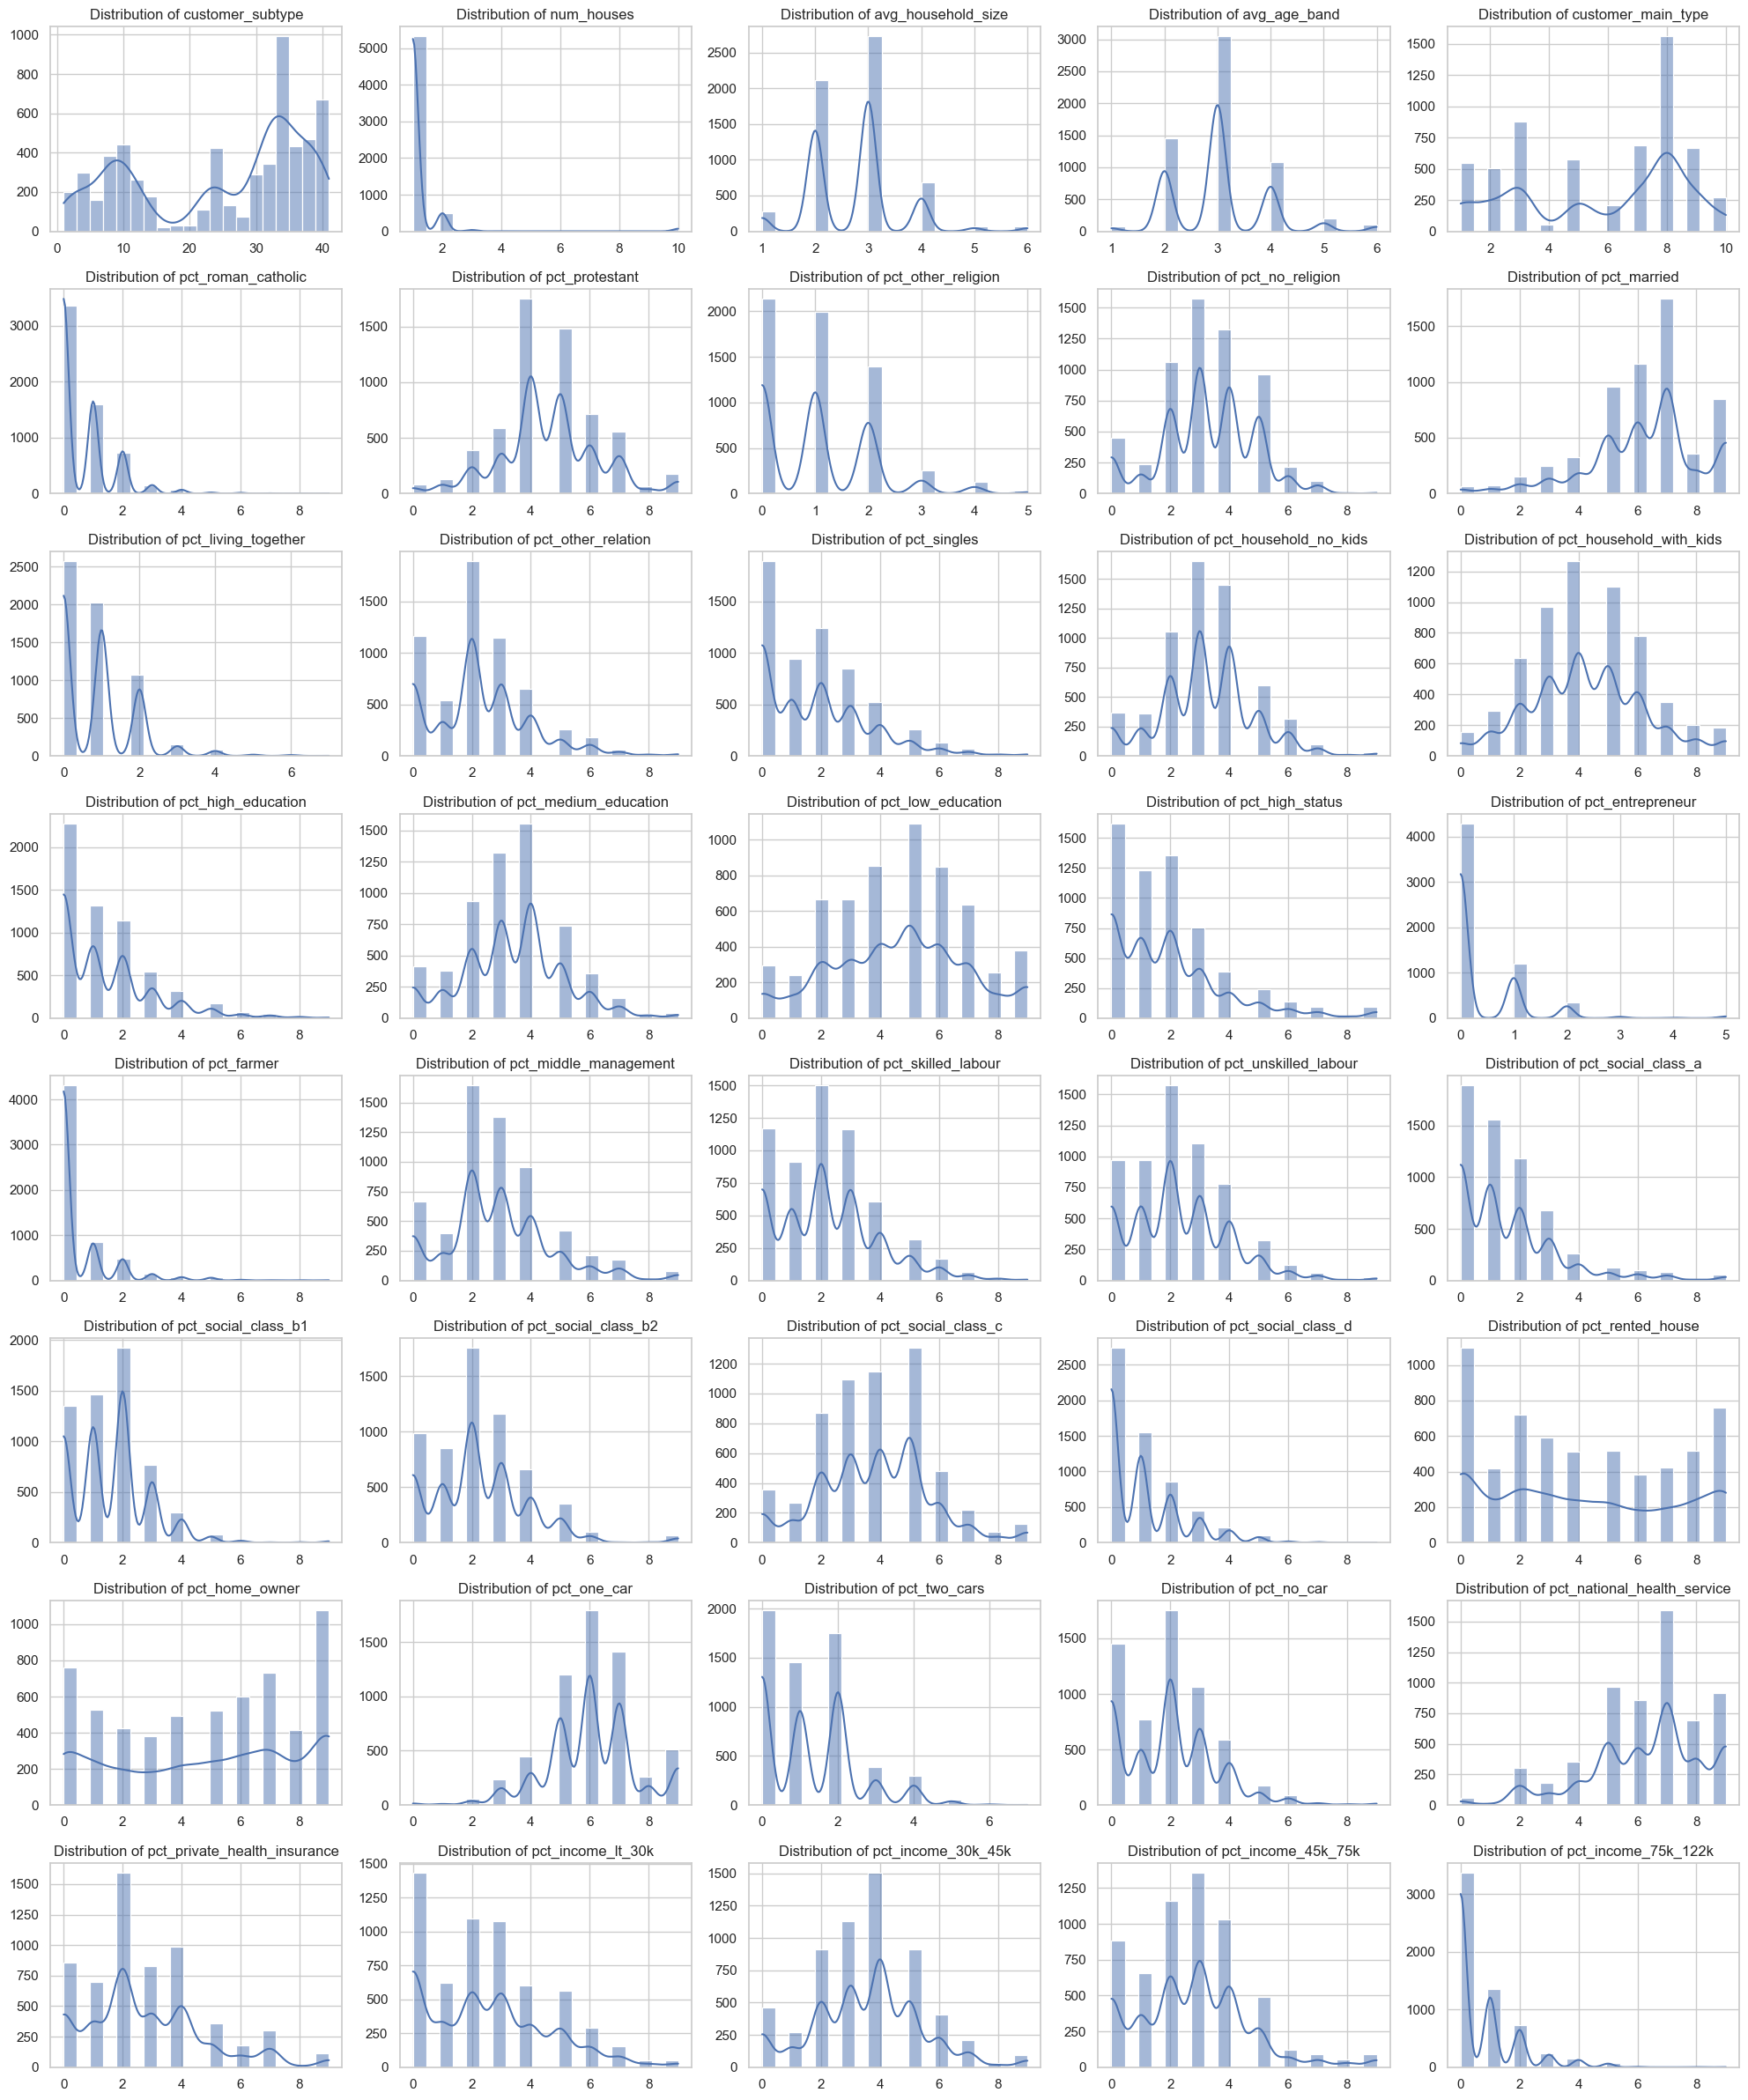

In [21]:
# 3. Distribution of the first 40 features
first_40_features = config.LONG_NAMES[:40]
plots.plot_feature_histograms(df_cleaned, first_40_features, n_cols=5)

## 5. Feature Engineering & Selection

We apply the `prune_by_correlation` function from `src/features.py` to remove highly collinear variables, reducing redundancy.

In [22]:
df_pruned, dropped_cols = features.prune_by_correlation(
    df_cleaned,
    target_col=config.TARGET_COL,
    thr=config.PRUNING_THRESHOLD,
    random_state=config.RANDOM_STATE
)

print(f"Original shape: {df_cleaned.shape} -> Pruned shape: {df_pruned.shape}")

Correlation Pruning: Dropped 4 columns with threshold > 0.85
Original shape: (5938, 86) -> Pruned shape: (5938, 82)


## 6. Define Features (X) and Target (y)

We separate our dataset into the feature matrix `X` and the target vector `y`.

In [23]:
y = df_pruned[config.TARGET_COL].astype(int)
X = df_pruned.drop(columns=[config.TARGET_COL])

## 7. Data Splitting

We use the `split_data` function from `src/modeling/train.py` to create stratified training (60%), validation (20%), and test (20%) sets.

In [24]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train.split_data(
    X,
    y,
    random_state=config.RANDOM_STATE
)

Data split complete:
  Train: 3562 samples
  Valid: 1188 samples
  Test:  1188 samples


## 8. Create Preprocessing Pipeline

We instantiate our `ColumnTransformer` using the `create_preprocessor` factory function from `src/features.py`. This object will be the first step in our `scikit-learn` modeling pipelines.

In [25]:
preprocessor = features.create_preprocessor(
    available_cols=X.columns,  
    static_nominal_cols=config.NOMINAL_COLS,
    static_ordinal_cols=config.ORDINAL_COLS,
    static_numeric_cols=config.NUMERIC_DISCRETE_COLS
)

preprocessor

Preprocessor created. Columns to be processed:
  Nominal: 1 (out of 2 defined)
  Ordinal: 57 (out of 60 defined)
  Numeric: 23 (out of 23 defined)


,transformers,"[('nom', ...), ('ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,False


## 9. Set MLflow Experiment

We set the experiment name for MLflow. All runs will be logged under this experiment.

In [28]:
# Set the tracking URI to the project's root mlruns folder
mlflow.set_tracking_uri(MLRUNS_URI)

# Now, set the experiment
mlflow.set_experiment(config.MLFLOW_EXPERIMENT_NAME)

print(f"MLflow tracking URI set to: {MLRUNS_URI}")
print(f"MLflow experiment set to: '{config.MLFLOW_EXPERIMENT_NAME}'")

2025/10/29 01:11:22 INFO mlflow.tracking.fluent: Experiment with name 'Insurance_Company_Benchmark' does not exist. Creating a new experiment.


MLflow tracking URI set to: file:///c:/Users/jorge/OneDrive/Documents/GIT/insurance_company_project/mlruns
MLflow experiment set to: 'Insurance_Company_Benchmark'


## 10. Model 1: Logistic Regression (Baseline)

We run our baseline model. The `train_logistic_regression` function now automatically logs all parameters, metrics, and the model artifact to MLflow under the `mlflow_run_name`.

In [29]:
lr_results = train.train_logistic_regression(
    X_train, y_train, 
    X_valid, y_valid, 
    X_test, y_test, 
    preprocessor,
    random_state=config.RANDOM_STATE,
    mlflow_run_name="Logistic_Regression_Baseline"
)


--- Training Model 1: Logistic_Regression_Baseline ---
MLflow Run ID: fee44013c6f44b58a5416c4b0d430b37
Training complete in 8.44s
--- Logistic Regression Evaluation (on Test Set) ---
  model: Logistic Regression
  best_threshold_gmean: 0.4200
  valid_gmean: 0.6655
  test_pr_auc: 0.1576
  test_roc_auc: 0.6755
  test_gmean: 0.6142
  test_recall_TPR: 0.6000
  test_specificity_TNR: 0.6288
  test_f1_score: 0.1594
  test_confusion_matrix: 
[[703 415]
 [ 28  42]]
  mlflow_run_id: fee44013c6f44b58a5416c4b0d430b37
  mlflow_model_uri: file:///c:/Users/jorge/OneDrive/Documents/GIT/insurance_company_project/mlruns/880908600915000557/fee44013c6f44b58a5416c4b0d430b37/artifacts/model


## 11. Model 2: XGBoost (Optimized)

We run our advanced model. The `train_xgboost` function logs the `RandomizedSearchCV` best parameters, final metrics, and the optimized model artifact to MLflow.

In [30]:
xgb_results = train.train_xgboost(
    X_train, y_train, 
    X_valid, y_valid, 
    X_test, y_test, 
    preprocessor, 
    random_state=config.RANDOM_STATE,
    mlflow_run_name="XGBoost_Optimized_Search"
)


--- Training Model 2: XGBoost_Optimized_Search ---
MLflow Run ID: dc83f2c4dcf84a05aabf44a5d10f3635
Fitting 3 folds for each of 10 candidates, totalling 30 fits


2025/10/29 01:12:32 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.



RandomizedSearchCV complete in 20.57s
Best AP (cv): 0.1284

--- XGBoost Evaluation (on Test Set) ---
  model: XGBoost
  best_threshold_gmean: 0.0900
  valid_gmean: 0.6853
  test_pr_auc: 0.1152
  test_roc_auc: 0.6916
  test_gmean: 0.6481
  test_recall_TPR: 0.6286
  test_specificity_TNR: 0.6682
  test_f1_score: 0.1814
  test_confusion_matrix: 
[[747 371]
 [ 26  44]]
  best_cv_avg_precision: 0.1284
  mlflow_run_id: dc83f2c4dcf84a05aabf44a5d10f3635
  mlflow_model_uri: file:///c:/Users/jorge/OneDrive/Documents/GIT/insurance_company_project/mlruns/880908600915000557/dc83f2c4dcf84a05aabf44a5d10f3635/artifacts/model


## 12. Compare Experiments and Register Best Model

We use MLflow's API to search the runs from our experiment, compare them in a DataFrame, and then register the best-performing model (XGBoost) to the Model Registry.

In [34]:
# Get ALL runs from our experiment
all_runs_df = mlflow.search_runs(
    experiment_names=[config.MLFLOW_EXPERIMENT_NAME],
    order_by=["metrics.test_pr_auc DESC"]
)

# --- Filter for parent runs using pandas ---
# Parent runs are those where the 'tags.mlflow.parentRunId' column is NaN
df_runs = all_runs_df[all_runs_df['tags.mlflow.parentRunId'].isna()].copy()
# ---

# Define columns to display
cols_to_show = [
    "tags.mlflow.runName", 
    "metrics.test_pr_auc", 
    "metrics.test_roc_auc", 
    "metrics.test_gmean", 
    "metrics.best_threshold_gmean",
    "params.n_estimators", 
    "params.max_depth",
    "params.learning_rate",
    "status",
    "artifact_uri"
]

# Filter df_runs to only columns that actually exist (to avoid KeyErrors)
display_cols = [col for col in cols_to_show if col in df_runs.columns]

print("--- MLflow Run Comparison (Parent Runs Only) ---")
display(df_runs[display_cols])

--- MLflow Run Comparison (Parent Runs Only) ---


,tags.mlflow.runName,metrics.test_pr_auc,metrics.test_roc_auc,metrics.test_gmean,metrics.best_threshold_gmean,status,artifact_uri
0,Logistic_Regression_Baseline,0.157635,0.675518,0.614232,0.42,FINISHED,file:///c:/Users/jorge/OneDrive/Documents/GIT/...
1,XGBoost_Optimized_Search,0.115218,0.691605,0.648062,0.09,FINISHED,file:///c:/Users/jorge/OneDrive/Documents/GIT/...


In [35]:
# Register the best model (XGBoost) to the MLflow Model Registry
model_name = "Caravan_Insurance_Predictor"
model_uri = xgb_results["mlflow_model_uri"]
run_id = xgb_results["mlflow_run_id"]

print(f"Registering model from run_id: {run_id}")

registered_model = mlflow.register_model(
    model_uri=model_uri,
    name=model_name,
    tags={
        "model_type": "XGBoost",
        "pr_auc": xgb_results["test_pr_auc"],
        "run_id": run_id
    }
)

print("\n--- Model Registration Complete ---")
print(f"Model Name: {registered_model.name}")
print(f"Model Version: {registered_model.version}")

# --- Set an alias for the new version ---
client = MlflowClient()
alias_name = "champion"
print(f"\nSetting alias '{alias_name}' for {registered_model.name} version {registered_model.version}")

client.set_registered_model_alias(
    name=registered_model.name,
    alias=alias_name,
    version=registered_model.version
)

print("--- Alias Set Successfully ---")

Registering model from run_id: dc83f2c4dcf84a05aabf44a5d10f3635

--- Model Registration Complete ---
Model Name: Caravan_Insurance_Predictor
Model Version: 4

Setting alias 'champion' for Caravan_Insurance_Predictor version 4
--- Alias Set Successfully ---


Registered model 'Caravan_Insurance_Predictor' already exists. Creating a new version of this model...
Created version '4' of model 'Caravan_Insurance_Predictor'.


## 13. How to View Results

All experiments, parameters, metrics, and model artifacts are now logged.

To launch the MLflow visualization UI:
1.  Open a terminal or command prompt.
2.  Navigate to your project's root directory (the one containing `mlruns` folder).
3.  Run the command: `mlflow ui`
4.  Open `http://127.0.0.1:5000` in your web browser.